# Predicting Air Quality Index - Random Forest Regressor

## Datasource: https://www.kaggle.com/datasets/waqi786/global-air-quality-dataset

#### PM2.5: The concentration of fine particulate matter with a diameter of less than 2.5 micrometers (µg/m³).
#### PM10: The concentration of particulate matter with a diameter of less than 10 micrometers (µg/m³).
#### NO2: The concentration of nitrogen dioxide (µg/m³).
#### SO2: The concentration of sulfur dioxide (µg/m³).
#### CO: The concentration of carbon monoxide (mg/m³).
#### O3: The concentration of ozone (µg/m³).
#### Temperature: The temperature at the time of measurement (°C).
#### Humidity: The humidity level at the time of measurement (%).
#### Wind Speed: The wind speed at the time of measurement (m/s)


In [1]:
# Installing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/global_air_quality_data_10000.csv')

In [3]:
# Intially our dataset does not contain our target value (Air Quality Index)
# so we will create this using the polluant values provided.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         10000 non-null  object 
 1   Country      10000 non-null  object 
 2   Date         10000 non-null  object 
 3   PM2.5        10000 non-null  float64
 4   PM10         10000 non-null  float64
 5   NO2          10000 non-null  float64
 6   SO2          10000 non-null  float64
 7   CO           10000 non-null  float64
 8   O3           10000 non-null  float64
 9   Temperature  10000 non-null  float64
 10  Humidity     10000 non-null  float64
 11  Wind Speed   10000 non-null  float64
dtypes: float64(9), object(3)
memory usage: 937.6+ KB


### Creating a function to calculate the AQI (Air Quality Index) based on Environmental Projection Agency (EPA) Standards

In [4]:
def calculate_aqi(concentration, breakpoints):
    for bp in breakpoints:
        if bp['C_lo'] <= concentration <= bp['C_hi']:
            I_lo = bp['I_lo']
            I_hi = bp['I_hi']
            C_lo = bp['C_lo']
            C_hi = bp['C_hi']
            aqi = ((I_hi - I_lo) / (C_hi - C_lo)) * (concentration - C_lo) + I_lo
            return round(aqi)
    return None

# Break points for each pollutant provided by EPA

In [5]:
pm25_breakpoints = [
    {'I_lo': 0, 'I_hi': 50, 'C_lo': 0, 'C_hi': 12},
    {'I_lo': 51, 'I_hi': 100, 'C_lo': 12.1, 'C_hi': 35.4},
    {'I_lo': 101, 'I_hi': 150, 'C_lo': 35.5, 'C_hi': 55.4},
    {'I_lo': 151, 'I_hi': 200, 'C_lo': 55.5, 'C_hi': 150.4},
    {'I_lo': 201, 'I_hi': 300, 'C_lo': 150.5, 'C_hi': 250.4},
    {'I_lo': 301, 'I_hi': 500, 'C_lo': 250.5, 'C_hi': 500.4},
]

pm10_breakpoints = [
    {'I_lo': 0, 'I_hi': 50, 'C_lo': 0, 'C_hi': 54},
    {'I_lo': 51, 'I_hi': 100, 'C_lo': 55, 'C_hi': 154},
    {'I_lo': 101, 'I_hi': 150, 'C_lo': 155, 'C_hi': 254},
    {'I_lo': 151, 'I_hi': 200, 'C_lo': 255, 'C_hi': 354},
    {'I_lo': 201, 'I_hi': 300, 'C_lo': 355, 'C_hi': 424},
    {'I_lo': 301, 'I_hi': 500, 'C_lo': 425, 'C_hi': 604},
]

no2_breakpoints = [
    {'I_lo': 0, 'I_hi': 50, 'C_lo': 0, 'C_hi': 53},
    {'I_lo': 51, 'I_hi': 100, 'C_lo': 54, 'C_hi': 100},
    {'I_lo': 101, 'I_hi': 150, 'C_lo': 101, 'C_hi': 360},
    {'I_lo': 151, 'I_hi': 200, 'C_lo': 361, 'C_hi': 649},
    {'I_lo': 201, 'I_hi': 300, 'C_lo': 650, 'C_hi': 1249},
    {'I_lo': 301, 'I_hi': 500, 'C_lo': 1250, 'C_hi': 2049},
]

so2_breakpoints = [
    {'I_lo': 0, 'I_hi': 50, 'C_lo': 0, 'C_hi': 35},
    {'I_lo': 51, 'I_hi': 100, 'C_lo': 36, 'C_hi': 75},
    {'I_lo': 101, 'I_hi': 150, 'C_lo': 76, 'C_hi': 185},
    {'I_lo': 151, 'I_hi': 200, 'C_lo': 186, 'C_hi': 304},
    {'I_lo': 201, 'I_hi': 300, 'C_lo': 305, 'C_hi': 604},
    {'I_lo': 301, 'I_hi': 500, 'C_lo': 605, 'C_hi': 1004},
]

co_breakpoints = [
    {'I_lo': 0, 'I_hi': 50, 'C_lo': 0, 'C_hi': 4.4},
    {'I_lo': 51, 'I_hi': 100, 'C_lo': 4.5, 'C_hi': 9.4},
    {'I_lo': 101, 'I_hi': 150, 'C_lo': 9.5, 'C_hi': 12.4},
    {'I_lo': 151, 'I_hi': 200, 'C_lo': 12.5, 'C_hi': 15.4},
    {'I_lo': 201, 'I_hi': 300, 'C_lo': 15.5, 'C_hi': 30.4},
    {'I_lo': 301, 'I_hi': 500, 'C_lo': 30.5, 'C_hi': 50.4},
]

o3_breakpoints = [
    {'I_lo': 0, 'I_hi': 50, 'C_lo': 0, 'C_hi': 0.054},
    {'I_lo': 51, 'I_hi': 100, 'C_lo': 0.055, 'C_hi': 0.070},
    {'I_lo': 101, 'I_hi': 150, 'C_lo': 0.071, 'C_hi': 0.085},
    {'I_lo': 151, 'I_hi': 200, 'C_lo': 0.086, 'C_hi': 0.105},
    {'I_lo': 201, 'I_hi': 300, 'C_lo': 0.106, 'C_hi': 0.200},
    {'I_lo': 301, 'I_hi': 500, 'C_lo': 0.201, 'C_hi': 0.604},
]


In [6]:
# Calculate AQI for each pollutant
df['AQI_PM2.5'] = df['PM2.5'].apply(lambda x: calculate_aqi(x, pm25_breakpoints))
df['AQI_PM10'] = df['PM10'].apply(lambda x: calculate_aqi(x, pm10_breakpoints))
df['AQI_NO2'] = df['NO2'].apply(lambda x: calculate_aqi(x, no2_breakpoints))
df['AQI_SO2'] = df['SO2'].apply(lambda x: calculate_aqi(x, so2_breakpoints))
df['AQI_CO'] = df['CO'].apply(lambda x: calculate_aqi(x, co_breakpoints))
df['AQI_O3'] = df['O3'].apply(lambda x: calculate_aqi(x, o3_breakpoints))

# Calculate the overall AQI
df['AQI'] = df[['AQI_PM2.5', 'AQI_PM10', 'AQI_NO2', 'AQI_SO2', 'AQI_CO', 'AQI_O3']].max(axis=1)



In [7]:
#Drop calculated columns
df.drop(['AQI_PM2.5', 'AQI_PM10', 'AQI_NO2', 'AQI_SO2', 'AQI_CO', 'AQI_O3'], axis=1, inplace=True)
df.head()

,City,Country,Date,PM2.5,PM10,NO2,SO2,CO,O3,Temperature,Humidity,Wind Speed,AQI
0,Bangkok,Thailand,2023-03-19,86.57,25.19,99.88,30.63,4.46,36.29,17.67,59.35,13.76,167.0
1,Istanbul,Turkey,2023-02-16,50.63,97.39,48.14,8.71,3.40,144.16,3.46,67.51,6.36,138.0
2,Rio de Janeiro,Brazil,2023-11-13,130.21,57.22,98.51,9.92,0.12,179.31,25.29,29.30,12.87,190.0
3,Mumbai,India,2023-03-16,119.70,130.52,10.96,33.03,7.74,38.65,23.15,99.97,7.71,184.0
4,Paris,France,2023-04-04,55.20,36.62,76.85,21.85,2.00,67.09,16.02,90.28,14.16,150.0


# Exploratory Data Analysis

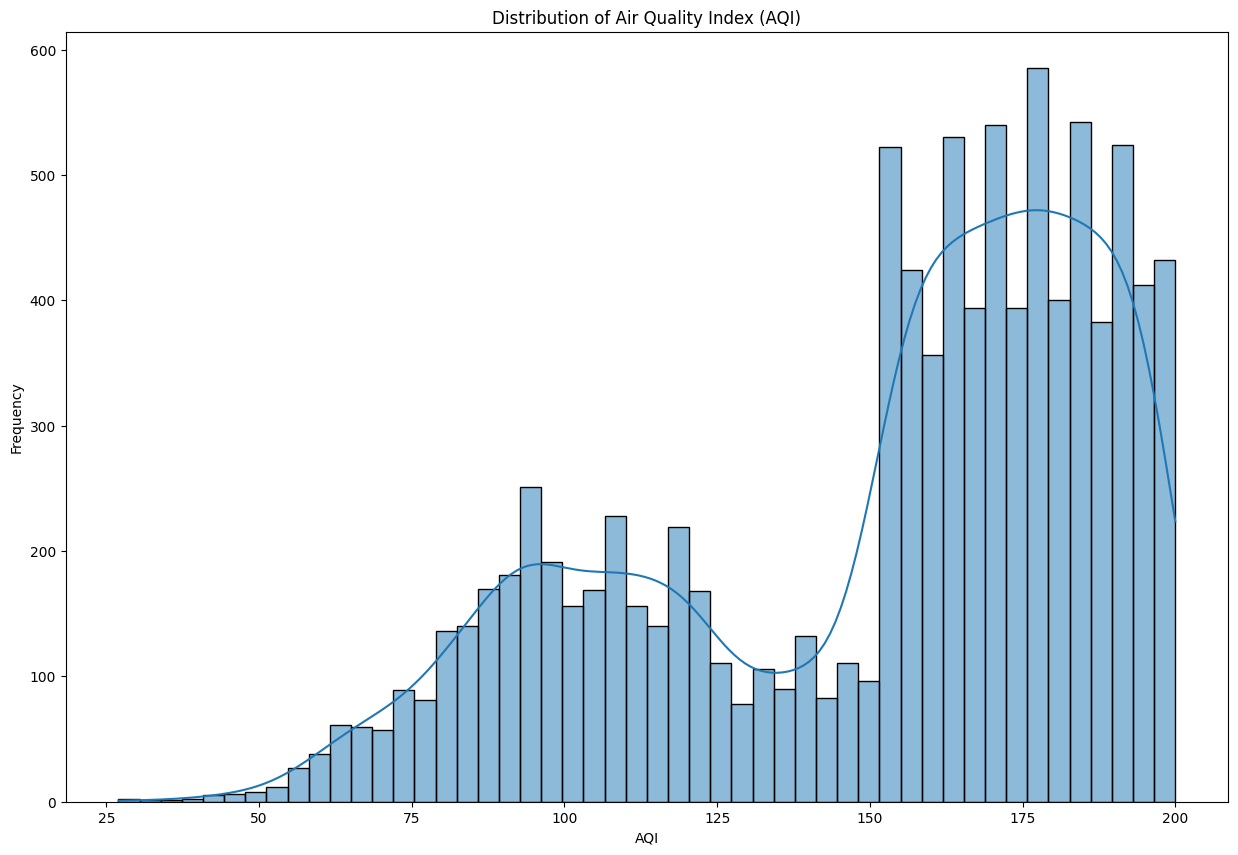

In [8]:
plt.figure(figsize=(15, 10))
sns.histplot(df['AQI'], bins=50, kde=True)
plt.title('Distribution of Air Quality Index (AQI)')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()

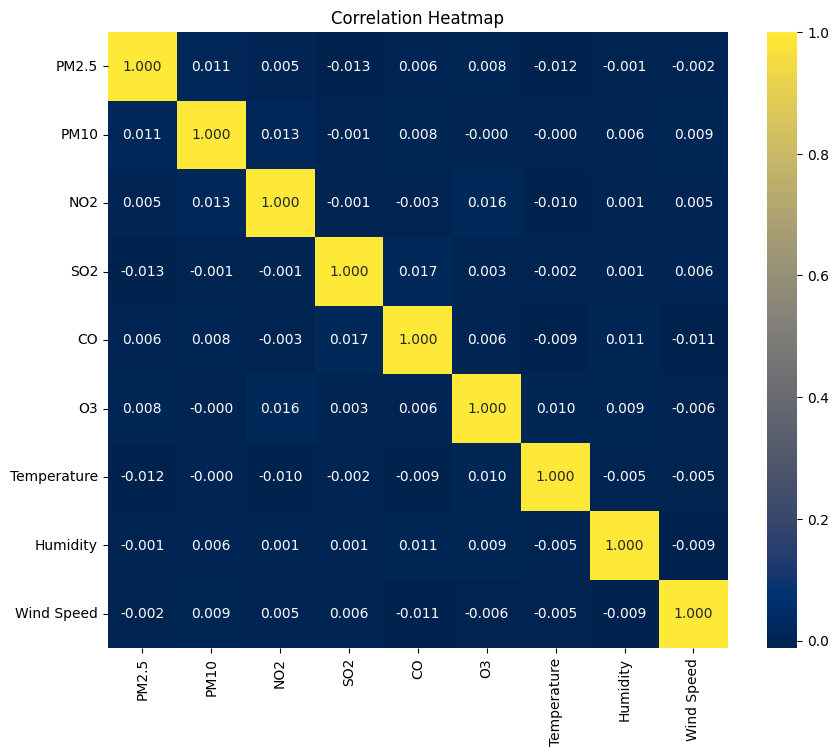

In [9]:
heatmap= df.corr(method='pearson', numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap, annot=True, cmap='cividis', fmt='.3f')
plt.title('Correlation Heatmap')
plt.show()

### Data Preprocessing

In [11]:
# parsing the date column for better model performance
df['Date'] = pd.to_datetime(df['Date'])
df['day'] = df['Date'].dt.dayofweek
df['is_weekend'] = (df['day']>=5).astype(int)
df['month'] = df['Date'].dt.month

#Drop unnecessary columns after data extracted
df.drop(['Date','City', 'Country'], axis=1, inplace=True)


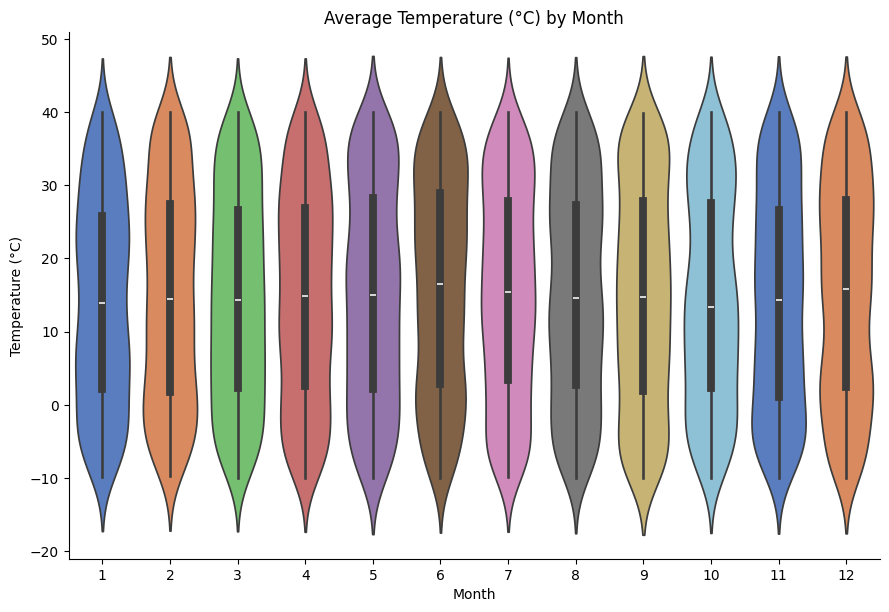

In [13]:
sns.catplot(data=df, x='month', y='Temperature',
            kind='violin',
            height=6, aspect=1.5,
            palette='muted')

plt.title('Average Temperature (°C) by Month')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.show()

# Model Construction

In [15]:
X = df.drop('AQI', axis=1)
y = df['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
#Normalizing input features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
model = RandomForestRegressor(n_estimators=100, random_state=42,
                              max_depth=5, min_samples_split=10,
                               min_samples_leaf=4,)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [34]:
#Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 15.4633
R-squared: 0.9890


In [29]:
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validated R² scores:", scores)
print("Mean CV R²:", scores.mean())

Cross-validated R² scores: [0.98611937 0.98680497 0.98841247 0.98828191 0.98820199]
Mean CV R²: 0.9875641410961243


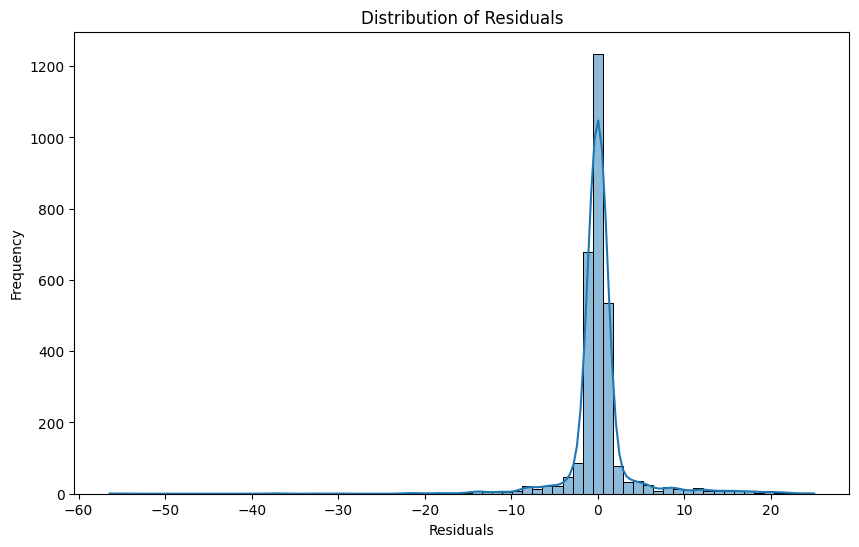

In [30]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=70, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

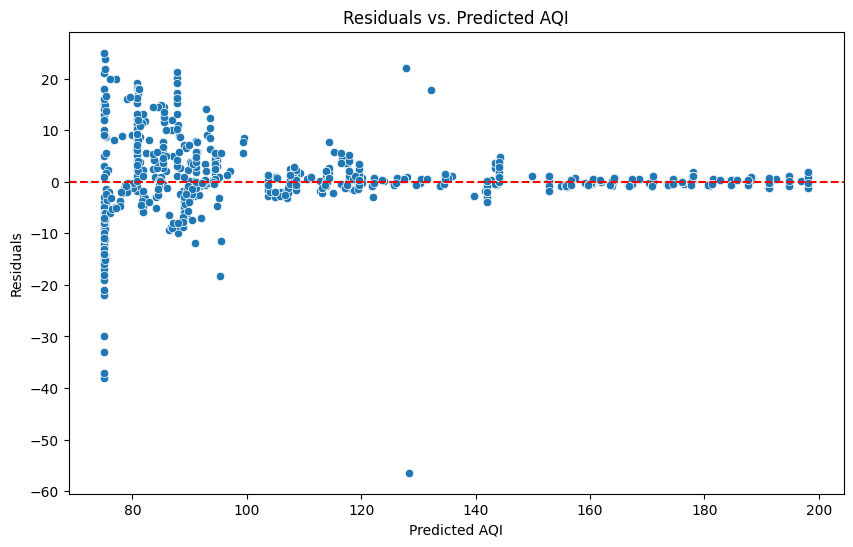

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted AQI')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted AQI')
plt.show()

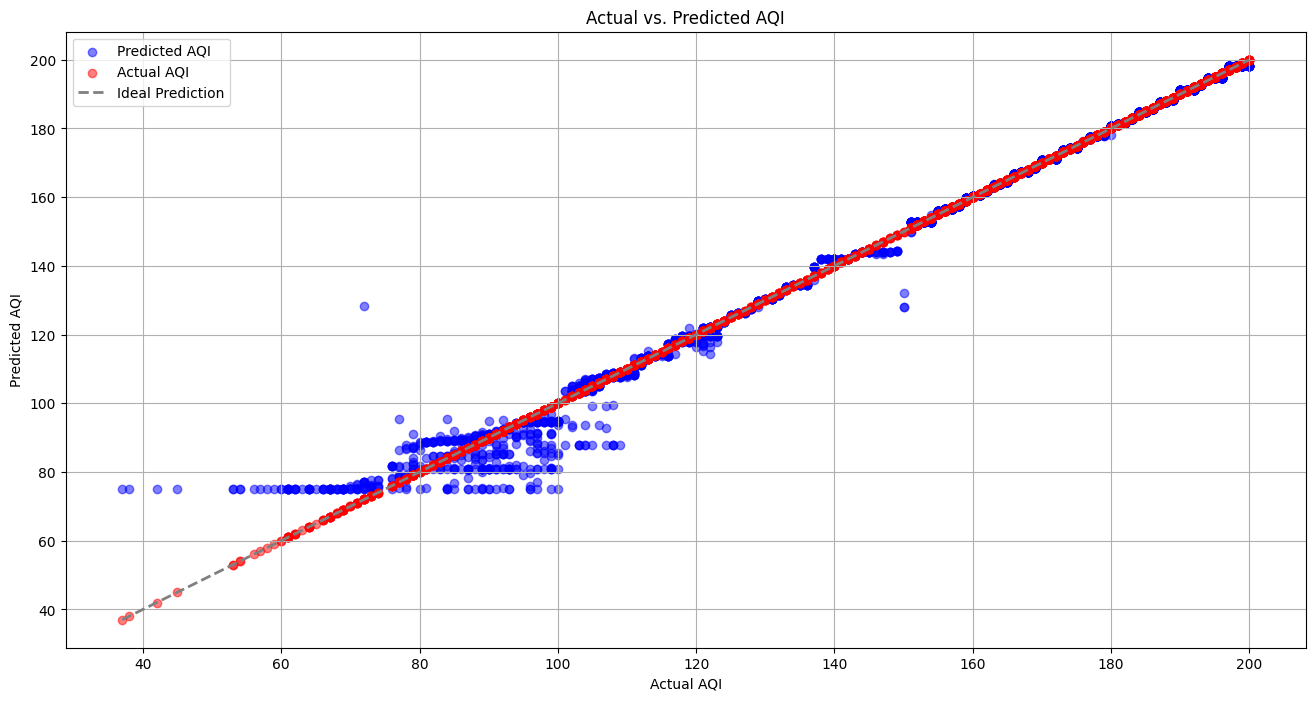

In [32]:
plt.figure(figsize=(16, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted AQI')
plt.scatter(y_test, y_test, alpha=0.5, color='red', label='Actual AQI')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         linestyle='--', color='gray', linewidth=2, label='Ideal Prediction')
plt.title('Actual vs. Predicted AQI')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.legend()
plt.grid(True)
plt.show()

# *Model evaluation* :
The random forest regressor demonstrates exceptional overall performance in predicting Air Quality Index values, achieving an outstanding R-squared of 0.9890 and maintaining consistent cross-validation scores (mean CV R² = 0.9876), which indicates robust generalization capability with minimal overfitting. The model excels particularly in predicting moderate to high AQI values (150-200 range), where predictions align closely with actual values along the ideal prediction line. However, the model exhibits some weaknesses in the lower AQI range (75-100), where increased prediction variability is evident in the residuals plot. This reduced accuracy at lower AQI values can be attributed to the bimodal distribution of the target variable, which shows distinct peaks around 95 and 175 - the sparse data density in the valley between these peaks makes it inherently more challenging for the model to learn accurate patterns for intermediate AQI values. Despite this limitation, the normally distributed residuals centered around zero and the absence of systematic bias patterns confirm that the model maintains statistical validity across the prediction range, making it highly suitable for air quality forecasting applications.